# <div style='text-align:center; color:red'><i> Project: N-Body Simulation</i></div>
### <div style='text-align:center; color:lightblue'>Hayden Raymond Ramm (hrr32)</div>

### <b style='color:lightblue'>Table of Contents</b>
[Naive Algorithm](#part-1-naive-method-using-pairwise-interactions-for-all-bodies) <br/>
[Barnes-Hut Method](#part-2-implementing-the-barnes-hut-algorithm)<br/>
[Fast Multipole Method](#part-3-fast-multipole-method)<br/>
[Conclusion](#conclusion)<br/>

### <b style='color:lightblue'>Part 1: Naive Method Using Pairwise Interactions for All Bodies</b>

The naive method is perhaps the most direct, and relies on calculating all pairwise interactions directly between each particle. This obviously gives a complexity of O(N<sup>2</sup>), and though this is not a large obstacle for a small number of bodies (i.e. 100 or so bodies), though it quickly becomes cumbersome for any orders of magnitude beyond that point (one could obviously argue that it was cumbersome for any number of bodies to begin with).

The N-body pairwise calculation has been around for centuries- Newton originally proposed the form of the pairwise sum when formulating his theory of gravitation. Mathematically simple (as we essentially just need to solve 4N differential equations for 2D motion- x, y, v<sub>x</sub> and v<sub>y</sub>), the method is nevertheless highly computationally costly for most real-world applications, where the number of bodies to be simulated is often millions or more. Below, we show the code used to implement the naive method as well as a graph of time taken for each simulation against N<sup>2</sup>, with N as the number of bodies in the simulation.

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import timeit
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

#The values set here are used in all three algorithm implementations

G = 1 #Value of gravitational constant
dt = 1 #Value of time step for Euler's method
softening = 0.2 #Softening length
xlim, ylim = 100, 100 #Axes limits
N = 100 #Total number of planetary bodies to be simulated
vmax = 1 #Maximum velocity

In [2]:
#Universe and Planet classes, partially adapted from Part IB Computing Handbook, but obviously with significant modification

class Universe():
    def __init__(self, fig = 0, ax = 0):
        self.N = N
        self.planets = []
        self.fig = fig
        self.ax = ax

    def initialise_axes(self):
        self.fig, self.ax = plt.subplots()
        self.fig.tight_layout()

    def fixAxes(self):
        self.ax.set_xlim((0, xlim))
        self.ax.set_ylim((0, ylim))

    def addPlanet(self, planet):
        self.planets.append(planet)
        
    def updatePlanets(self):
        for planet in self.planets:
            planet.updatePosition()
            

    def updatePlanets_andDraw(self):
        self.ax.clear()
        for planet in self.planets:
            planet.updatePosition()
            planet.draw() #for when I want to display the planets
        
    def gravity_Planets(self):
        for i, first in enumerate(self.planets):
            for other in self.planets[i+1:]:
                first.gravity(other)
    
    def empty(self):
        self.planets = []

#PLANET CLASS

class Planet():
    def __init__(
            self, 
            univ,
            position, 
            velocity,
            mass = 1, 
            ):
        self.mass = mass
        self.position = position
        self.velocity = velocity
        self.univ = univ

        #Add planet upon declaration
        #self.univ.addPlanet(self)

    def gravity(self, other):
        dx = self.position[0]-other.position[0]
        dy = self.position[1]-other.position[1]

        r = np.sqrt(dx**2 + dy**2)
        r_hat = np.divide(np.subtract(other.position, self.position),r)

        force = np.multiply(((G * self.mass * other.mass)/ ((r**2 + softening**2)))**1.5,r_hat)

        #Pairwise interactions
        sgn = 1
        for body in self, other:
            acceleration = np.divide(force,body.mass)
            dv = np.multiply(acceleration,dt*sgn)
            body.velocity = np.add(body.velocity, dv)
            sgn*=-1

    def updatePosition(self):
        self.position = np.add(self.position, np.multiply(self.velocity,dt))

    def draw(self):
        self.univ.ax.plot(
            self.position[0], self.position[1], marker = 'o', 
            markersize = 5, color = "black"
        )

In [3]:
#Initialise Solar System
System1 = Universe()

#Set up
time_naive = []
val_of_N = []

def add_N_planets(num, sys):
    for x in range (0,num):
        sys.addPlanet(Planet(System1, 
                                    position = np.multiply(np.random.rand(2),(xlim+ylim)/2), 
                                    velocity=np.multiply(np.random.rand(2),np.random.randint(-1*vmax,1*vmax))))
        
def grav_and_update(sys):
    sys.gravity_Planets()
    sys.updatePlanets()


def test_naive(number,sys):
    for j in range (0,number):
        add_N_planets(j, sys)
        starting_time = timeit.default_timer()
        grav_and_update(sys)
        ending_time = timeit.default_timer()
        t = ending_time - starting_time
        sys.empty()
        time_naive.append(t)
        val_of_N.append(j)

test_naive(N, System1)

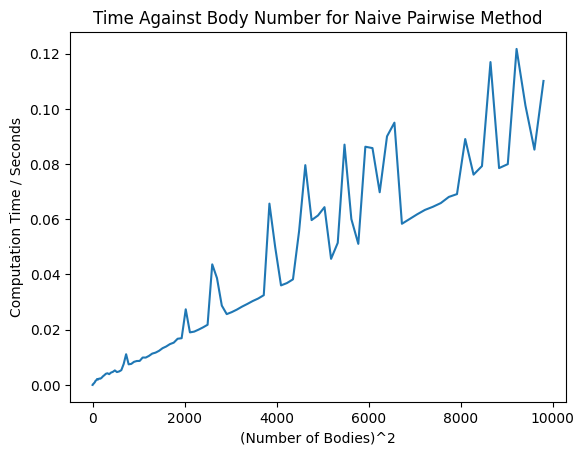

In [4]:
val_of_N_squared = np.multiply(val_of_N,val_of_N)

plt.plot(val_of_N_squared,time_naive)
plt.xlabel('(Number of Bodies)^2')
plt.ylabel('Computation Time / Seconds')
plt.title('Time Against Body Number for Naive Pairwise Method')
plt.show()

In [ ]:
System1.initialise_axes()
add_N_planets(N, System1)

def animate(i):
    print(f"The frame is {i}")
    System1.gravity_Planets()
    System1.updatePlanets_andDraw()
    System1.fixAxes()


anim = animation.FuncAnimation(System1.fig, animate, frames = 10, interval = 100)
plt.show()

### <b style='color:lightblue'>Part 2: Implementing the Barnes-Hut Algorithm</b>
#### <i>Using Nodes with 4 Children, adapting & modding code found here: https://github.com/ntta/barnes-hut-algorithm/blob/master/barneshut.py</i>
#### <b style='color:lightgreen'>Authors of the following code: User NTTA on Github and Hayden Raymond Ramm</b>

The first method we explore beyond the naive method is the Barnes-Hut, which uses a quadtree structure to divide the 2D plane into successively smaller boxes. We then assign each box a centre of mass coordinate and a "total mass" value. If the distance between a given particle A and the centre of mass coordinate of a given box is large enough, we can approximate the gravitational force on this particle as follows: we assume that the particle A effectively sees a single particle of mass M at position B, where M is the sum of masses in the box and B is the position of the box's centre of mass. This significantly reduces computation time by removing the cumbersome pairwise sums previously seen in the naive implementation, yielding an algorithm with complexity of order Nlog(N).

### <b style='color:lightblue'>What is a Quadtree?</b> ###

A quadtree is a hierarchical data structure often encountered in data handling, particularly image compression and storage. In a quadtree, each "node" has exactly four children.

Here, we iteratively divide the space into four nodes, before dividing each node into four "children" and subsequently dividing these nodes into four "grandchildren", etc.

<figure style='align:center'>

<img src='quadtree.png' style='background-color:lightblue; display:block; margin-left:auto; margin-right:auto' alt='quadtree.png'/>
<figcaption style='text-align:center'>A schematic representation of a quadtree. <i>Source: Wikipedia</i></figcaption>

</figure>

In [5]:
from matplotlib import patches #useful for dividing the grid into rectangles

frac = 0.5 #If box separation / distance between particles is less than this, 
#we can treat as pairwise interaction between a single mass and a big particle of mass M at a far-away box's centre of mass
#This is a free paramater of the simulation. Obviously, any value over 1 is absurd, and values closer to 1 are going to be less
#faithful to the actual problem.

class Node:
    total_mass = None #Expect some number
    centre_of_mass = None #Expect some coordinates [x,y]
    box = None
    child_node = None


def define_box(array):
     #Find the limits of our system for a given system
    if len(array) == 0 or len(array) == 1:
        return None
    
    #Modified to reflect my earlier code- the planets x,y coordinates exist in their position arrays
    #Iteratively find the min and max x and y values of our system

    xmin, xmax, ymin, ymax = array[0].position[0], array[0].position[0], array[0].position[1], array[0].position[1]

    for i in range(len(array)):
        if array[i].position[0] > xmax:
            xmax = array[i].position[0]
        if array[i].position[0] < xmin:
            xmin = array[i].position[0]
        if array[i].position[1] > ymax:
            ymax = array[i].position[1]
        if array[i].position[1] < ymin:
            ymin = array[i].position[1]
    if xmax - xmin == ymax - ymin:
        return xmin, xmax, ymin, ymax
    elif xmax - xmin > ymax - ymin:
        return xmin, xmax, ymin, ymax+((xmax-xmin)-(ymax-ymin))
    else:
        return xmin, xmax+((ymax-ymin)-(xmax-xmin)), ymin, ymax
    #Final provisions ensure that we have a square system


def quadrant_of_particle(box, x, y):
    if y >= (box[3] + box[2])/2:
        if x <= (box[1] + box[0])/2:
            return 0 #Top left quadrant
        else:
            return 1 #Top Right quadrant
    else:
        if x >= (box[1] + box[0])/2:
            return 2 #Bottom Right
        else:
            return 3 #Bottom Left

        
def box_of_quadrant(box, quadrant): #Gives us the xmin, xmax, ymin, ymax coordinates of the quadrant
    x = (box[1] + box[0])/2
    y = (box[3] + box[2])/2

    #if in quadrant 0, xmin = box[0], ymax = box[3] etc.

    if quadrant == 0: #top left
        return box[0], x, y, box[3]
    
    if quadrant == 1: #top right
        return x, box[1], y, box[3]
    
    if quadrant == 2: #bottom right
        return x, box[1], box[2], y
    
    if quadrant == 3: #bottom left
        return box[0], x, box[2], y


def insert_quadrant(root, x, y, m):

    #Possibility 1
    if root.total_mass is None: #Empty quadrants will have the first particle's mass inserted
        root.total_mass = m
        root.centre_of_mass = [x, y] #Sets the centre of mass to the particles if previously empty
        return
    
    #Possibility 2
    elif root.child_node is None: #What if the node has no children? :(
        root.child_node = [None, None, None, None] #Four children
        old_quadrant = quadrant_of_particle(root.box, root.centre_of_mass[0], root.centre_of_mass[1]) #Finds which quadrant the particle was in
        if root.child_node[old_quadrant] is None:
            root.child_node[old_quadrant] = Node() #First grandchild node
            root.child_node[old_quadrant].box = box_of_quadrant(root.box, old_quadrant) #Uses old quadrant's box to define child's box
        insert_quadrant(root.child_node[old_quadrant], root.centre_of_mass[0], root.centre_of_mass[1], root.total_mass) #Inserts new quadrant at child's location
        new_quadrant = quadrant_of_particle(root.box, x, y)
        if root.child_node[new_quadrant] is None:
            root.child_node[new_quadrant] = Node() #Second grandchild node
            root.child_node[new_quadrant].box = box_of_quadrant(root.box, new_quadrant)
        insert_quadrant(root.child_node[new_quadrant], x, y, m)

        #Updating the centre of mass:
        root.centre_of_mass[0] = (root.centre_of_mass[0]*root.total_mass + x*m)/(root.total_mass + m)
        root.centre_of_mass[1] = (root.centre_of_mass[1]*root.total_mass + y*m)/(root.total_mass + m)
        root.total_mass += m

    #Possibility 3- Not an empty quadrant
    else:
        new_quadrant = quadrant_of_particle(root.box, x, y)
        if root.child_node[new_quadrant] is None:
            root.child_node[new_quadrant] = Node()
            root.child_node[new_quadrant].box = box_of_quadrant(root.box, new_quadrant)
        insert_quadrant(root.child_node[new_quadrant], x, y, m)

        #Updating the centre of mass:
        root.centre_of_mass[0] = (root.centre_of_mass[0]*root.total_mass + x*m)/(root.total_mass + m)
        root.centre_of_mass[1] = (root.centre_of_mass[1]*root.total_mass + y*m)/(root.total_mass + m)
        root.total_mass += m

def gravity_eqn(m1, x1, y1, m2, x2, y2):
    
    pos1 = [x1, y1]
    pos2 = [x2, y2]

    r = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + softening**2)
    r_hat = np.divide(np.subtract(pos2,pos1),r)

    f = np.multiply(G*m1*m2,np.divide(r_hat,r**3))

    return f[0], f[1] #X and Y components of force

def compute_gravity(root, x, y, m): #Returns x and y components of force on a body
    
    if root.total_mass == 0: #No force if massless
        return 0, 0
    
    if root.centre_of_mass[0] == x and root.centre_of_mass[1] == y and root.total_mass == m: 
        #If root is just the one particle, prevent interaction with self
        return 0, 0
    
    box_length = root.box[1] - root.box[0]
    dx = np.sqrt((x - root.centre_of_mass[0])**2)
    dy = np.sqrt((y - root.centre_of_mass[1])**2)
    r = np.sqrt(dx**2 + dy**2 + softening**2)

    if box_length/r < frac or root.child_node is None:
        return gravity_eqn(m, x, y, root.total_mass, root.centre_of_mass[0], root.centre_of_mass[1])

    else:
        fx = 0.0
        fy = 0.0
        for i in range(4): #Call the computation on each four child nodes
            if root.child_node[i] is not None:
                fx += compute_gravity(root.child_node[i],x,y,m)[0]
                fy += compute_gravity(root.child_node[i],x,y,m)[1]
        return fx, fy


def Barnes_Hut(sys, j):
    bodies = sys.planets
    particles_force = {}
    root = Node()
    root.centre_of_mass = []
    root.box = define_box(bodies)

    for i in range(j):
        insert_quadrant(root, bodies[i].position[0], bodies[i].position[1], bodies[i].mass)

    for i in range(j):
        total_fx, total_fy = compute_gravity(root,bodies[i].position[0],bodies[i].position[1],bodies[i].mass)
        particles_force[i] = (total_fx, total_fy)

    for i in range(j):
        fx, fy = particles_force[i]
        bodies[i].velocity[0] += fx / bodies[i].mass * dt
        bodies[i].velocity[1] += fy / bodies[i].mass * dt

        bodies[i].position[0] += bodies[i].velocity[0] * dt
        bodies[i].position[1] += bodies[i].velocity[1] * dt

In [6]:
time_BH = []

def test_BH(number,sys):
    for j in range (1,number):
        add_N_planets(j, sys)
        starting_time = timeit.default_timer()
        Barnes_Hut(sys, j)
        ending_time = timeit.default_timer()
        t = ending_time - starting_time
        sys.empty()
        time_BH.append(t)
        #val_of_N_BH.append(j)

In [7]:
System2 = Universe()
test_BH(N, System2)

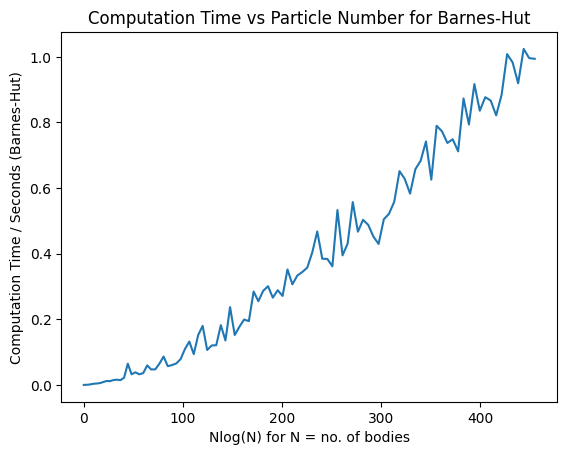

In [8]:
log_val_of_N_BH = np.log(val_of_N[1:])
nlogn = np.multiply(val_of_N[1:],log_val_of_N_BH)

plt.plot(nlogn,time_BH)
plt.xlabel('Nlog(N) for N = no. of bodies')
plt.ylabel('Computation Time / Seconds (Barnes-Hut)')
plt.title('Computation Time vs Particle Number for Barnes-Hut')
plt.show()

### <b style='color:lightblue'>Part 3: Fast Multipole Method</b>

The fast multipole method uses Taylor expansion to drastically reduce the computation time needed to calculate N-body interactions in Coulombic potentials. <b><i style='color:red'>Based on code: https://github.com/lbluque/fmm/blob/master/fmm.py which I have modified and adapted</i></b>

The fast multipole method (FMM) bears many similarities to the Barnes-Hut method- for example, it too has complexity NlogN, and makes use of a quadtree in two dimensions. Instead of directly calculating Newtonian interactions, the FMM relies on calculation of the potential of the particles in the grid due to "charge", though obviously this charge can easily be taken to be mass for gravitational force.

Here, the computation time's limiting factor is the number of terms we allow the program to expand up to; the code below is flexible at this respect and truncates the potential expansion after a specified n terms. I have run the program for various numbers of Taylor series terms before truncation- 5, 7, 10, 13 and 20, though after only a handful of terms, the FMM approximates the potential quite well (terms of even moderately high order will be fairly small). This is another advantage of the algorithm- it requires only a limited expansion of a (fairly) easy Taylor series.

Roughly speaking, the algorithm consists of dividing the 2d space into several levels of "meshed grid".

Many of the steps below yield a series of coefficients. Below, in the code, I have just stored these in several useless variables (_1, _2, garbage_can, etc.) as we're only interested in computation time.


#### <b style='color:lightblue'>Steps</b>:
<ol>
<b style='color:lightgreen'>UPWARDS PASS</b>
<li>Calculate the potential due to a number of particles within four child nodes at the finest mesh level. We will repeat this for all levels of "refinement", i.e. all levels between the coarsest and finest grids. Segments (boxes) on the same refinement level sharing a boundary are nearest neighbours.</li>
<li>Use the multipole-to-multipole expansion to find the multipole expansion for the parent node of these four children.</li>
<li>Repeat until 2nd coarsest level reached (coarsest level is not useful as it is just one cell containing all particles).</li><br/>
<b style='color:lightgreen'>DOWNWARDS PASS</b>
<li>Use multipole-to-local expansion to compute interactions between boxes sufficiently well-separated at each refinement level</li>
<li>Use local-to-local expansion to calculate potential exerted by parent box on its children.</li>
<li>Continue for all child nodes until we are on the finest mesh level (i.e. no more child nodes to divide into).</li>
</ol>

### <b style='color:lightblue'>The Mathematics of the FMM Algorithm</b> ###
We can use a Taylor series to calculate the potential due to the charged/massive bodies at the finest mesh level in the quadtree structure:
$$\phi(z) = Qlog(z) + \sum_{k=1}^{\infty} \frac{a_k}{k}$$

Where we have:

$$a_k = \sum_{i=1}^{m} \frac{-q_i z_i^k}{k}$$

where $q_i$ is the charge of each individual particle in the space, and $z_i$ is the position of each particle, and there are <i>m</i> particles in the space.

$$Q = \sum_{i=1}^{m} q_i$$

denotes total charge.

So this is relatively simple- we just calculate the straightforward Taylor series for a group of charges for $\left| z \right| < r$ for some given radius of a circle $r$.

If we perform the above Taylor series expansion for a collection of <i>m</i> charges inside of each node at the finest mesh level, we can use a multipole-to-multipole expansion for four "child" nodes and hence "shift" these expansions to the shared corner the four nodes share, i.e. the <b>centre of the parent node</b>.

<figure style='align:center'>
<img style='margin-left:auto; margin-right:auto; display:block' src='m2m.png' alt='m2m.png'/>
<figcaption style='text-align:center'>Demonstration of what it means to <i>"shift"</i> individiual child multipole expansions to a common centre on the upwards pass of the FMM algorithm. <i>Image sourced from Hanliang Gao</i>.</figcaption>
</figure>

We can then use a multipole-to-local expansion to calculate mutual interaction between well-separated parent nodes at each mesh level, before proceeding with the downwards pass using a multipole-to-local expansion.

<figure>
<img src='FMM_up_and_down_pass.png' alt='FMM_up_and_down_pass.png' style='display:block; margin-left:auto; margin-right:auto'/>
<figcaption style='text-align:center'>Image showing the action of the multipole-to-multipole expansion on the upwards pass, before using a multipole-to-local expansion at the coarse mesh level. This is followed by a downwards pass back up to the finest mesh level using a multipole-to-local Taylor expansion, and subsequently multipole-to-local expansions within the layer. <i>Source: Hanliang Gao</i></figcaption>
</figure>

In [9]:
def factorial(i):
    if i == 0:
        return 1

    j = i - 1
    fact = i
    while j>0:
        fact *= j
        j = j-1

    return fact

def binom(n,k):
    binom_coeff = factorial(n) / (factorial(k) * factorial(n-k))

    return binom_coeff

def multipole_expansion(bodies, nterms, center = (0,0)):
    '''
    This is the multipole expansion corresponding to phi(z) and involves an iteration over all charges present in the N bodies 
    '''

    coefficients = np.empty(nterms+1)

    C_0 = 0
    for i, body in enumerate(bodies):
        C_0 += float(bodies[i][2])

    coefficients[0] = C_0

    a_k = 0
    for k in range(1,nterms+1):
        for j, body in enumerate(bodies):
            a_k = -1 * np.sum((bodies[j][2] * complex(bodies[j][0]-center[0], bodies[j][1]-center[1]))**k / k)
        
        coefficients[k] = a_k

    return coefficients

def multipole_shift(original_coefficients, z0):
    '''
    Update the coefficients for the multipole expansion for some given central
    shift z0
    '''

    shift_coefficients = np.empty_like(original_coefficients)

    shift_coefficients[0] = original_coefficients[0]

    for l in range(1, len(original_coefficients)):
        b_l = 0
        for k in range(1,l):
            b_l += original_coefficients[k]*z0**(l-k) * \
                         binom(l-1,k-1)
        
        b_l -= original_coefficients[0]*z0**l / l
            

        shift_coefficients[l] = b_l
    
    return shift_coefficients

def multipole_to_local(original_coefficients, z0):
    '''
    Compute coefficients inside of a circle
    '''

    m_to_l_coefficients = np.empty_like(original_coefficients)

    b_0 = 0
    for k in range(1,len(original_coefficients)):
        b_0 += (-1)**k * original_coefficients[k] / z0**k
    b_0 += original_coefficients[0]*np.log(-1*z0)

    m_to_l_coefficients[0] = b_0

    for l in range (1, len(original_coefficients)):
        b_l = 0
        for k in range(1,len(original_coefficients)):
            b_l += (-1)**k * original_coefficients[k] *binom(l+k-1, k-1) / z0**k
        b_l *= 1 / z0**l
        b_l -= original_coefficients[0] / (l*z0**l)
        m_to_l_coefficients[l] = b_l

    return m_to_l_coefficients

def local_shift(original_coefficients, z0):

    local_shift_coeff = np.empty_like(original_coefficients)

    for l in range(0,len(original_coefficients)):
        k_sum = 0
        for k in range(l,len(original_coefficients)):
            k_sum += original_coefficients[k] * binom(k,l) * -1*(z0)**(k-l)
        
        local_shift_coeff[l] = k_sum
    return local_shift_coeff

def _outer_mpexp(tnode, nterms):
    """Compute outer multipole expansion recursively"""

    if tnode.is_leaf():
        tnode.outer = multipole_expansion(tnode.get_points(), nterms=nterms, center=tnode.center)
    else:
        tnode.outer = np.zeros((nterms + 1), dtype=complex)
        for child in tnode:
            _outer_mpexp(child, nterms)
            z0 = complex(*child.center) - complex(*tnode.center)
            tnode.outer += multipole_shift(child.outer, z0)

In [10]:
'''Note: Original Author is Luis Barroso-Luque, with additional edits and fixes by me'''

eps = 7./3 - 4./3 -1

def _loopchildren(parent):
    for child in parent._children:
        if child._children:
            for subchild in _loopchildren(child):
                yield subchild
        yield child


class Node():
    """Single Tree Node"""
    DISREGARD = (1,2,0,3)
    CORNER_CHILDREN = (3, 2, 0, 1)


    def __init__(self, width, height, x0, y0, points=None,
                 children=None, parent=None, level=0):

        self._points = []
        self._children = children
        self._cneighbors = 4*[None,]
        self._nneighbors = None
        self._cindex = 0
        self.parent = parent
        self.x0, self.y0, self.w, self.h = x0, y0, width, height
        self.verts = ((x0, x0 + width), (y0, y0 + height))
        self.center = (x0 + width/2, y0 + height/2)
        self.level = level
        self.inner, self.outer = None, None

        if points is not None:
            self.add_points(points)

    def __iter__(self):
        if self._has_children():
            for child in self._children:
                yield child

    def __len__(self):
        if self._points is not None:
            return len(self._points)
        return 0

    def _has_children(self):
        return (self._children is not None)

    def _get_child(self, i):
        if self._children is None:
            return self
        return self._children[i]

    def _split(self):
        if self._has_children():
            return

        w = self.w/2
        h = self.h/2
        x0, y0 = self.verts[0][0], self.verts[1][0]

        # Create children order [NW, NE, SW, SE] -> [0,1,2,3]
        self._children = [Node(w, h, xi, yi, points=self._points,
                               level=self.level+1, parent=self)
                          for yi in (y0 + h, y0) for xi in (x0, x0 + w)]
        for i, c in enumerate(self._children):
            c._cindex = i


    def _contains(self, x, y):
        return ((x >= self.verts[0][0] and x < self.verts[0][1]) and
                (y >= self.verts[1][0] and y < self.verts[1][1]))

    def is_leaf(self):
        return (self._children is None)

    def thresh_split(self, thresh):
        if len(self) > thresh:
            self._split()
        if self._has_children():
            for child in self._children:
                child.thresh_split(thresh)


    def set_cneighbors(self):

        if not self._children:
            return
        
        for i, child in enumerate(self._children):
            # Set sibling neighbors
            sn = (abs(1 + (i^1) - i), abs(1 + (i^2) - i))
            child._cneighbors[sn[0]] = self._children[i^1]
            child._cneighbors[sn[1]] = self._children[i^2]
            # Set other neighbors from parents neighbors
            pn = tuple(set((0,1,2,3)) - set((sn)))
            nc = lambda j, k: j^((k+1)%2+1)
            child._cneighbors[pn[0]] = (self._cneighbors[pn[0]]._get_child(nc(i, pn[1]))
                                        if self._cneighbors[pn[0]] is not None
                                        else None)
            child._cneighbors[pn[1]] = (self._cneighbors[pn[1]]._get_child(nc(i, pn[0]))
                                        if self._cneighbors[pn[1]] is not None
                                        else None)
            # Recursively set cneighbors
            if child._has_children():
                child.set_cneighbors()

    def add_points(self, points):
        if self._has_children():
            for child in self._children:
                child.add_points(points)
        else:
            for d in points:
                if self._contains(d[0], d[1]):
                    self._points.append(d)

    def get_points(self):
        return self._points


    def traverse(self):
        if self._has_children():
            for child in _loopchildren(self):
                yield child

    @property
    def nearest_neighbors(self):
        if self._nneighbors is not None:
            return self._nneighbors

        # Find remaining nearest neighbors of same level
        nn = [cn._cneighbors[(i+1)%4]
              for i, cn in enumerate(self._cneighbors)
              if cn is not None and cn.level == self.level]
        # Find remaining nearest neigbor at lower levels #So hacky!
        nn += [cn._cneighbors[(i+1)%4]._get_child(self.CORNER_CHILDREN[i])
               for i, cn in enumerate(self._cneighbors)
               if cn is not None and cn._cneighbors[(i+1)%4] is not None and
               (cn.level < self.level and i != self.DISREGARD[self._cindex])]

        nn = [n for n in self._cneighbors + nn if n is not None]
        self._nneighbors = nn
        return nn

    def interaction_set(self):
        nn, pn = self.nearest_neighbors, self.parent.nearest_neighbors
        int_set = []
        for n in pn:
            if n._has_children():
                int_set += [c for c in n if c not in nn]
            elif n not in nn:
                int_set.append(n)
        return int_set


class QuadTree():
    """Quad Tree Class"""

    def __init__(self, points, thresh, bbox=(1,1), boundary='wall'):
        self.threshold = thresh
        self.root = Node(*bbox, 0, 0)
        if boundary == 'periodic':
            self.root._cneighbors = 4*[self.root,]
        elif boundary == 'wall':
            self.root._cneighbors = 4*[None,]
        else:
            raise AttributeError('Boundary of type {} is'
                                 ' not recognized'.format(boundary))
        self._build_tree(points)
        self._depth = None

    def _build_tree(self, points):
        self.root.add_points(points)
        self.root.thresh_split(self.threshold)
        self.root.set_cneighbors()

    def __len__(self):
        l = len(self.root)
        for node in self.root.traverse():
            l += len(node)
        return l

    def __iter__(self):
        for points in self.root.get_points():
            yield points

    @property
    def depth(self):
        if self._depth is None:
            self._depth = max([node.level for node in self.root.traverse()])
        return self._depth

    @property
    def nodes(self):
        return [node for node in self.root.traverse()]

    def traverse_nodes(self):
        for node in self.root.traverse():
            yield node


def build_tree(points, tree_thresh=None, bbox=None, boundary='wall'):
    if bbox is None:
        coords = np.array([(p[0], p[1]) for p in points])
        bbox = (max(coords[:, 0]) + eps, max(coords[:, 1]) + eps)
    if tree_thresh is None:
        tree_thresh = 5#max(len(points)//10, 5)  # Something less error prone?

    return QuadTree(points, tree_thresh, bbox=bbox, boundary=boundary)

In [11]:
'''Here I have written some code separating the upwards and downwards passes of the multidimensional mesh structure.
Some of my colleagues also tried to code the FMM solution using a large multidimensional array, encoding each box's position in 
the grid (e.g. its index level, total mass contained etc.) but this quickly becomes messy and is hard to debug. Though I am trying to
implement it as well as it's more intuitive than the more complex code implemented above.

We've made use of complex numbers to separate x and y unit coordinates into orthogonal directions in the complex plane. In some places,
depending on what was useful at the time, these are converted from (x,y) position tuples stored for each coordinate
'''

def downPass(root):

    #Inner expansions for cells

    z0 = complex(root.parent.center[0],root.parent.center[1]) - complex(root.center[0],root.center[1])
    root.inner = multipole_shift(root.parent.inner, z0)

    for tin in root.interaction_set():
        z0 = complex(*tin.center) - complex(*root.center)
        root.inner += multipole_to_local(tin.outer, z0)

    if not root._has_children():
        z0 = complex(*root.center)
        coefficients = root.inner

        _ = np.empty_like(coefficients)
        for particle in root.get_points():
            _ += coefficients #Direct calculation

        
        _1 = 0
        for nearest_neighbor in root._nneighbors:
            selfbodies = root.get_points()
            nnbodies = nearest_neighbor.get_points()

            for sbody in selfbodies:
                for nnbody in nnbodies:
                    dx = nnbody[0] - sbody[0] #Reminder- body[0] = x, body[1] = y, body[2] = mass
                    dy = nnbody[1] - sbody[1]

                    r = np.sqrt(dx**2 + dy**2)
                    

                    _1 -= sbody[2]*np.log(r)
        
        garbage_can = potential_DirectSum(root.get_points())

    else:
        for child in root._children:
            downPass(child) #Recursively implement the downwards pass on all children in the root

def upwardsPass(root, nterms):

    if root.has_no_children():
        root.outer = multipole_expansion(root.points, nterms, center=root.center)
    else:
        root.outer = np.zeros(nterms, dtype = complex)
        for child in root.children:
            upwardsPass(child, nterms)
            z0 = complex(*child.center) - complex(*root.center)
            root.oyter += multipole_shift(child.outer, z0)


def potential_DirectSum(particles):
    """Direct sum calculation of all-to-all potential"""

    phi = np.zeros((len(particles),))
    
    for i, particle in enumerate(particles):
        for source in (particles[:i] + particles[i+1:]):
            dx = particle[0] - source[0]
            dy = particle[1] - source[1]
            r = np.sqrt(dx**2 + dy**2)
            phi[i] -= particle[2]*np.log(r)

    return phi


def calculate_FMM(tree, nterms=5):
    """Same as above but takes a prebuilt tree"""
    (tree.root, nterms)
    tree.root.inner = np.zeros((nterms + 1), dtype=complex)
    any(downPass(child) for child in tree.root)


def Fast_MM(points, nterms, bbox=None, tree_thresh=None,  boundary='wall'):
    tree = build_tree(points, tree_thresh, bbox=bbox, boundary=boundary)
    _outer_mpexp(tree.root, nterms)
    tree.root.inner = np.zeros((nterms + 1), dtype=complex)
    any(downPass(child) for child in tree.root)

In [12]:
System3 = Universe()

def test_FMM(number,sys, nterms, timearr):
    val_of_N_FMM = []
    for j in range (1,number):

        val_of_N_FMM.append(j)
        add_N_planets(j, sys)
        points_FMM = np.empty((len(sys.planets),3))

        for i, planet in enumerate(sys.planets):
            points_FMM[i][0] = planet.position[0]
            points_FMM[i][1] = planet.position[1]
            points_FMM[i][2] = planet.mass

        starting_time = timeit.default_timer()
        Fast_MM(points_FMM, nterms, bbox=None, tree_thresh=None, boundary='wall')
        ending_time = timeit.default_timer()
        t = ending_time - starting_time
        sys.empty()
        timearr.append(t)
        #val_of_N_BH.append(j)
    
    return val_of_N

In [17]:
#Test for 5 terms
time_FMM5 = []
N_FMM_5 = test_FMM(N, System3, 5, time_FMM5)

time_FMM7 = []
N_FMM_5 = test_FMM(N, System3, 7, time_FMM7)

time_FMM10 = []
N_FMM_5 = test_FMM(N, System3, 10, time_FMM10)

time_FMM13 = []
N_FMM_5 = test_FMM(N, System3, 13, time_FMM13)

time_FMM20 = []
N_FMM_5 = test_FMM(N, System3, 20, time_FMM20)

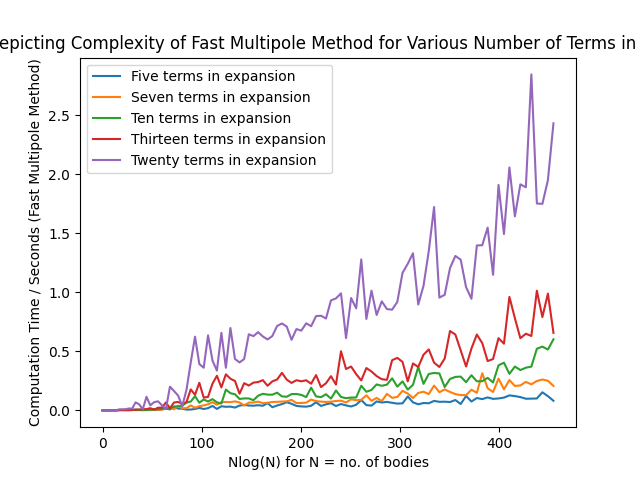

In [16]:
log_val_of_N_FMM = np.log(N_FMM_5)
nlogn_FMM = np.multiply(N_FMM_5,log_val_of_N_FMM)

plt.plot(nlogn_FMM[1:],time_FMM5, label = 'Five terms in expansion')
plt.plot(nlogn_FMM[1:],time_FMM7, label = 'Seven terms in expansion')
plt.plot(nlogn_FMM[1:],time_FMM10, label = 'Ten terms in expansion')
plt.plot(nlogn_FMM[1:],time_FMM13, label = 'Thirteen terms in expansion')
plt.plot(nlogn_FMM[1:],time_FMM20, label = 'Twenty terms in expansion')
plt.xlabel('Nlog(N) for N = no. of bodies')
plt.ylabel('Computation Time / Seconds (Fast Multipole Method)')
plt.legend()
plt.title('Graph Depicting Complexity of Fast Multipole Method for Various Number of Terms in Expansion')
plt.show()

### <b style='color:lightblue'>Conclusion</b>

The project explored the implementation of 3 algorithms for a 2D space of particles:
<ul>
<li>Naive pairwise interaction calculations O(N<sup>2</sup>)</li>
<li>Barnes-Hut method using a quadtree O(NlogN)</li>
<li>Fast multipole method using a quadtree O(NlogN)</li>
</ul>

<p>The naive pairwise algorithm is really easy to code, but is pretty computationally costly due to its complexity. There is literally no algorithm that could be more complex than the naive method and get the job done- for each of the N particles, we calculate its N-1 interactions. How else could this complexity be increased? I don't think it can.</p>

<p>The Barnes-Hut method is conceptually easy and not much more difficult to code than the naive method. A lot of the structure of the Barnes-Hut method relies on mathematics already present in the pairwise method. In simple terms, we are dividing the whole 2D space of particles using quadtrees, taking the particles in each box A produced by the quadtree at the finest level and treating these particles A as one large massive particle A' from the perspective of other particle(s) B sufficiently far away from the box A. It's effectively just pairwise interaction, but cutting down on the number of pairs in a physically reasonable way.</p>

<p>The Fast Multipole Method is, at first sight, pretty much impenetrable mathematically, and very hard to grasp conceptually enough to write decent code. I made lots of attempts at doing this on my own, at one point trying to divide the whole space into some number of levels, each level being some 2<sup>M</sup> by 2<sup>M</sup> matrix, with M as the index level. I then generated a large multidimensional array, in which I encoded all of the boxes' centre positions on each level using complex numbers. I then tried to add another dimension encoding total charge, another dimension encoding the coefficients of the upwards pass... Things got messy quite quickly. Instead, I studied a method using quadtrees and adapted the code to fit with my pre-existing class definitions of universes and planets, and made the code compatible with my attributes (as I stored data in a different way to the code's original author).</p>

<p>In conclusion, for millions or hundreds of millions of particles, choosing one of the latter-two methods is an obvious "must-do"; pairwise calculations for such a large group would be time-consuming and impractical. However, the FMM and Barnes-Hut Method have their own weaknesses- we need to (ideally) use an adaptive quadtree so that we deal with particle clusters more accurately (essential if we are modelling clusters or galaxies of many particles floating around in empty space). What if a cluster is bisected (or more?) by the boundaries of boxes of non-adaptive quadtrees? Surely it doesn't make sense to take both halves separately and expand them around two different centre-points instead of just expanding around the cluster's centre. Would this pose a computational challenge? Probably. I currently don't even know how to approach the problem. I'm hoping to maybe have a go at it this summer.</p>